In [1]:
from ArielUtils.Constants import *
import numpy as np
from numpy import exp, pi

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [52]:
def fitness_function(distance, transit_duration, orbital_period, quality_metric, time_till_event=0, slewrate=SLEWRATE, settle_time = SETTLE_TIME, baseline_duration=None):
    if baseline_duration is None:
        baseline_duration = .5 * transit_duration

    wait_time = time_till_event - distance/slewrate + settle_time + baseline_duration
    if wait_time <= 0:
        F = 0
    else:
        F = (orbital_period)**3 * quality_metric**3 * 1/(wait_time+1)**3 * exp(-wait_time/orbital_period)
    return F, wait_time
    


N = 1000

distances = np.random.random(N)*pi/4
transit_durations = np.random.random(N)*300
orbital_periods = np.random.random(N)*10000
quality_metrics= np.random.random(N)*100
event_timing = np.random.random(N)*50

fitnesses = []
wait_times = []
for i in range(N):
    fit = fitness_function(distances[i],
                            transit_durations[i],
                            orbital_periods[i],
                            quality_metrics[i],
                            time_till_event=event_timing[i]
                            )
    fitnesses.append(fit[0])
    wait_times.append(fit[1])


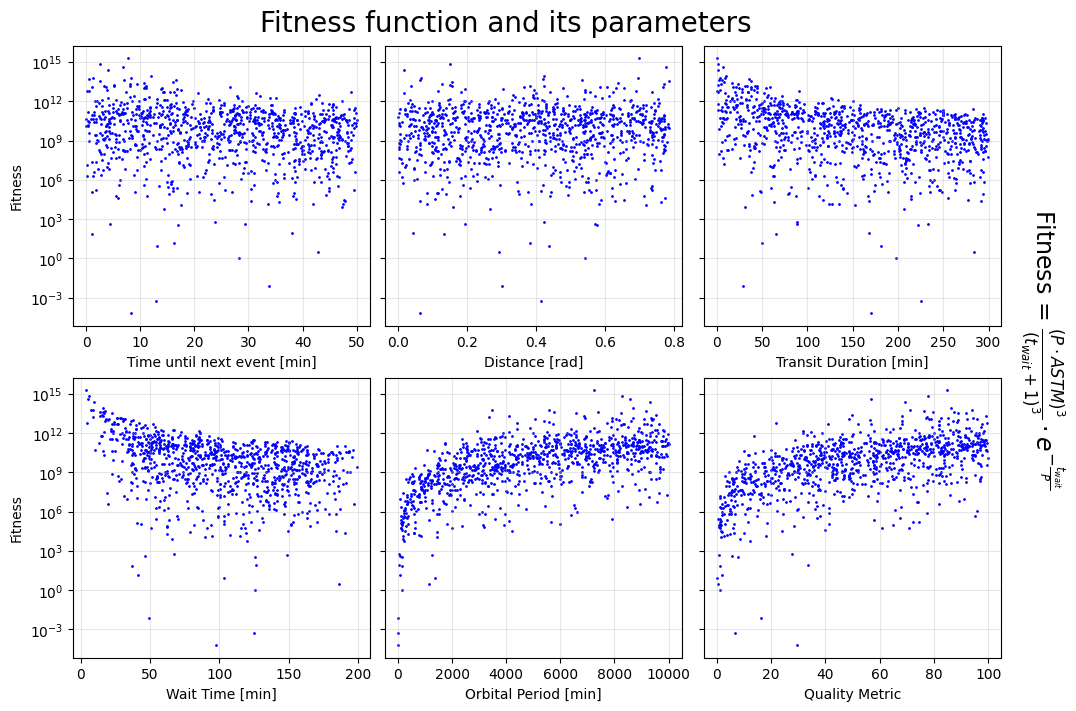

In [54]:
fig, axs = plt.subplots(2,3, sharey=True, layout='constrained', figsize=(10,7))

grid = True
alpha_grid = .3
size = 1
scale = 'log'
color = 'blue'

axs[0,0].scatter(event_timing, fitnesses, s=size, color=color)
axs[0,0].set_yscale(scale)
axs[0,0].set_ylabel('Fitness')
axs[0,0].set_xlabel('Time until next event [min]')
axs[0,0].grid(grid, alpha=alpha_grid)

axs[0,1].scatter(distances, fitnesses, s=size, color=color)
axs[0,1].set_yscale(scale)
axs[0,1].set_xlabel('Distance [rad]')
axs[0,1].grid(grid, alpha=alpha_grid)

axs[0,2].scatter(transit_durations, fitnesses, s=size, color=color)
axs[0,2].set_yscale(scale)
axs[0,2].set_xlabel('Transit Duration [min]')
axs[0,2].grid(grid, alpha=alpha_grid)

axs[1,0].scatter(wait_times, fitnesses, s=size, color=color)
axs[1,0].set_yscale(scale)
axs[1,0].set_ylabel('Fitness')
axs[1,0].set_xlabel('Wait Time [min]')
axs[1,0].grid(grid, alpha=alpha_grid)

axs[1,1].scatter(orbital_periods, fitnesses, s=size, color=color)
axs[1,1].set_yscale(scale)
axs[1,1].set_xlabel('Orbital Period [min]')
axs[1,1].grid(grid, alpha=alpha_grid)

axs[1,2].scatter(quality_metrics, fitnesses, s=size, color=color)
axs[1,2].set_yscale(scale)
axs[1,2].set_xlabel('Quality Metric')
axs[1,2].grid(grid, alpha=alpha_grid)

fig.text(1.03,.71, 
         r'Fitness = $\frac{(P \cdot ASTM )^3}{(t_{wait}+1)^3} \cdot e^{-\frac{t_{wait}}{P}}$ ', 
         fontsize=17, rotation=-90, rotation_mode='anchor')

fig.suptitle('Fitness function and its parameters', fontsize=20)

fig.savefig('Fitness/Fitness function and its parameters', bbox_inches='tight', dpi=300)
plt.show()